<a href="https://colab.research.google.com/github/jeffheaton/present/blob/master/youtube/gan/heatonresearch_gan_kit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Jeff Heaton](https://raw.githubusercontent.com/jeffheaton/present/master/images/github.jpg)

Copyright 2021 by [Jeff Heaton](https://www.youtube.com/channel/UCR1-GEpyOPzT2AO4D_eifdw), [released under Apache 2.0 license](https://github.com/jeffheaton/present/blob/master/LICENSE)
# StyleGAN2 ADA PyTorch Starter Project

I use this notebook as a starting point for many of the GAN experiments that I post to my [YouTube channel](https://www.youtube.com/channel/UCR1-GEpyOPzT2AO4D_eifdw). I based all of the code in this notebook on NVIDIA [StyleGAN2 ADA PyTorch](https://github.com/NVlabs/stylegan2-ada). This notebook contains code to help you:
Upload/Download Images/Files for use with StyleGAN2
Loading Premade GAN Neural Networks
Generating GANs from seed values
Automatically Cropping Face Images to StyleGAN2's Specs
Convert a real image into a StyleGAN2 latent vector
Morphing Between to Latent Vectors
Fine Tune a Latent Vector


# Install Software

Some software must be installed into Colab, for this notebook to work. We are specificially using these technologies:

* [Training Generative Adversarial Networks with Limited Data](https://arxiv.org/abs/2006.06676)
Tero Karras, Miika Aittala, Janne Hellsten, Samuli Laine, Jaakko Lehtinen, Timo Aila
* [One millisecond face alignment with an ensemble of regression trees](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf) Vahid Kazemi, Josephine Sullivan


In [1]:
import os
import sys
from google.colab import files
import torch

!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import cv2
import numpy as np

def display_lowres(img):
  plt.imshow(img)
  plt.title('source-gan')
  plt.show()

def seed2vec(g, seed):
  return np.random.RandomState(seed).randn(1, g.z_dim)

def load_vec(filename):
  result = np.load(filename)
  return result if 'w' not in result else result['w']
  
def save_vec(filename, lvec):
  numpy.save(filename,lvec)

def to_image(img):
  return PIL.Image.fromarray(img, 'RGB')

def render_gan(G, device, lvec, label=None, truncation_psi=1, noise_mode='const'):
  # noise mode 'const', 'random', 'none'
  z = torch.from_numpy(lvec).to(device)
  if label is None: label = torch.zeros([1, G.c_dim], device=device)
  if len(lvec.shape) == 2:
    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  else:
    img = G.synthesis(z, noise_mode=noise_mode)
  
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

--2021-07-23 00:16:05--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2.1’

shape_predictor_5_f 100%[===================>]   5.44M  6.20MB/s    in 0.9s    

2021-07-23 00:16:06 (6.20 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2.1’ saved [5706710/5706710]

bzip2: Output file shape_predictor_5_face_landmarks.dat already exists.
fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


# Accessing Data

### Mount Google Drive (GDRIVE)

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


### Upload an Image


In [12]:
import os
from google.colab import files

uploaded = files.upload()

for k, v in uploaded.items():
  _, ext = os.path.splitext(k)
  print(f"You uploaded /content/{k}")

Saving about-jeff-heaton-2020.jpg to about-jeff-heaton-2020.jpg
You uploaded /content/about-jeff-heaton-2020.jpg


### Download Image or File

In [ ]:
from google.colab import files
files.download("/content/cropped-jeff.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load a Pretrained GAN

In [3]:
STYLEGAN2_PKL_URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-70s-scifi/releases/download/v1/70s-scifi-gan-2020-12-12.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-minecraft/releases/download/v1/minecraft-gan-2020-12-22.pkl"

device = torch.device('cuda')
with dnnlib.util.open_url(STYLEGAN2_PKL_URL) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

# Generate GAN Images from Seeds

Generating image for seed 1000 (0/3) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


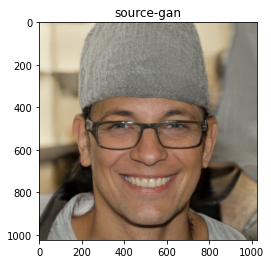

Generating image for seed 1001 (1/3) ...


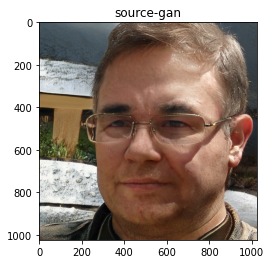

Generating image for seed 1002 (2/3) ...


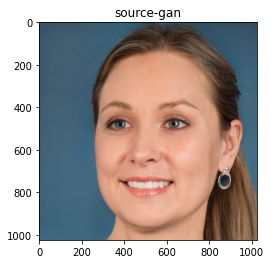

In [4]:
seeds = [1000,1001,1002]
OUTDIR = "/content/seeds"

# Create directory
try:
    os.makedirs(OUTDIR)
except OSError:
    pass

# Generate images.

for seed_idx, seed in enumerate(seeds):
  print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
  lv = seed2vec(G, seed)
  img = render_gan(G, device, lv)
  img.save(f'{OUTDIR}/seed{seed:04d}.png') # Save it
  #display(img2) # Display hi-res
  display_lowres(img)

## Load a Saved Latent Vector and Display

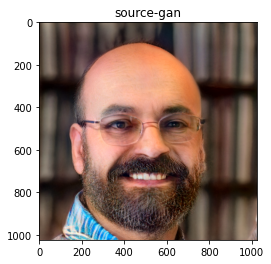

In [11]:
lvec = load_vec('/content/drive/MyDrive/data/gan/lvec/jeff/projected_w.npz')
img = render_gan(G, device, lvec)
display_lowres(img)

# Preprocess Images for Best StyleGAN Results

The following are helper functions for the preprocessing.

In [13]:
import cv2
import numpy as np
from PIL import Image
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)
  
  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  crop1 = left_eye2[0] - 385 
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

The following will preprocess and crop your images.  If you receive an error indicating multiple faces were found, try to crop your image better or obscure the background.  If the program does not see a face, then attempt to obtain a clearer and more high-resolution image.

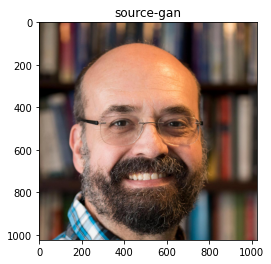

In [18]:
IMAGE_NAME = '/content/about-jeff-heaton-2020.jpg'
TARGET_NAME = '/content/jeff-cropped.png'

image = cv2.imread(IMAGE_NAME)
if image is None:
    raise ValueError("Source image not found")

cropped_image = crop_stylegan(image)
cv2.imwrite(TARGET_NAME, cropped_image)
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
display_lowres(cropped_image)

# Convert Image to a GAN

First, we convert the source to a GAN latent vector.  This process will take several minutes.

In [19]:
SOURCE_NAME = "/content/jeff-cropped.png"
OUT = "/content/jeff/"

cmd = f"python /content/stylegan2-ada-pytorch/projector.py --seed 303 --save-video 0 --num-steps 1000 --outdir={OUT} --target={SOURCE_NAME} --network={STYLEGAN2_PKL_URL}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.69 loss 24567.24
step    2/1000: dist 0.64 loss 27640.54
step    3/1000: dist 0.68 loss 27167.06
step    4/1000: dist 0.68 loss 26253.17
step    5/1000: dist 0.68 loss 24956.97
step    6/1000: dist 0.64 loss 23353.78
step    7/1000: dist 0.66 loss 21512.56
step    8/1000: dist 0.64 loss 19485.95
step    9/1000: dist 0.69 loss 17339.28
step   10/1

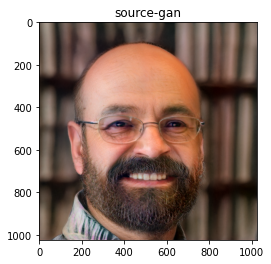

In [20]:
import cv2
import os
from matplotlib import pyplot as plt

img_gan_source = cv2.imread(os.path.join(OUT,'proj.png'))
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

# Build the Video

The following code builds a transition video between the two latent vectors previously obtained.

In [ ]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

STEPS = 150
FPS = 30
FREEZE_STEPS = 30

lvec = [
  np.load('/content/jeff/projected_w.npz')['w'],
  np.load('/content/thor/projected_w.npz')['w']
]

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for i in range(len(lvec)-1):
  lvec1 = lvec[i]
  lvec2 = lvec[i+1]

  diff = lvec2 - lvec1
  step = diff / STEPS
  current = lvec1.copy()

  for j in tqdm(range(STEPS)):
    z = torch.from_numpy(current).to(device)
    synth_image = G.synthesis(z, noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

    repeat = FREEZE_STEPS if (j==0 and i==0) or (j==(STEPS-1) and i==(len(lvec)-2)) else 1
    
    for i in range(repeat):
      video.append_data(synth_image)
    current = current + step


video.close()

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.



# Download your Video

If you made it through all of these steps, you are now ready to download your video.

In [ ]:
from google.colab import files
files.download("movie.mp4") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train a GAN from Images

I have an entire notebook for [this](https://github.com/jeffheaton/present/blob/master/youtube/gan/colab_gan_train.ipynb).

# Finetune an Image

If you find a seed that you like, you can fine tune it by adjusting the latent vector directly.  First, choose the seed to finetune.

In [ ]:
START_SEED = 3172

current = seed2vec(Gs, START_SEED)

Next, generate display the current vector. You will return to this point for each iteration of the finetuning.

In [ ]:
init_random_state(Gs, 10)
img = generate_image(Gs, current, 1.0)

SCALE = 0.5
display_image(img, SCALE)

Choose an explore size, this is the number of differnt potential images that will be chosen by moving in 10 different directions.  Run this code once initially, and then again anytime you wish to change the 10 directions you are exploring.  You might change the 10 directions if you are no longer seeing improvements.

In [ ]:
EXPLORE_SIZE = 25

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

In [ ]:
# Choose the direction to move.  Choose -1 for the initial iteration.   
MOVE_DIRECTION = -1
SCALE = 0.5

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
  print(f"Direction {i}")
  init_random_state(Gs, 10)
  z = current + mv
  img = generate_image(Gs, z, 1.0)
  display_image(img, SCALE)